In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import copy
from collections import defaultdict

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
%matplotlib inline

EPS = 0.00001

In [2]:
X = []
y = []
with open('tic-tac-toe.data.txt') as f:
    for l in f:
        s = l.strip().split(',')
        cur = []
        for x in s:
            if x == 'x':
                cur += [1, 0, 0]
            elif x == 'o':
                cur += [0, 1, 0]
            elif x == 'b':
                cur += [0, 0, 1]
        X.append(cur)
        if s[-1] == 'positive':
            y.append(1)
        else:
            y.append(0)

In [3]:
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

(958, 27) (958,)


In [4]:
print('negatives: {}, positives: {}'.format(sum(y==0), sum(y==1)))

negatives: 332, positives: 626


In [5]:
def k_fold(X, y, n_folds=10):
    splitted = []
    for i in range(n_folds):
        indices = np.arange(len(y))
        np.random.shuffle(indices)
        test_indices = indices[:int(len(indices) / n_folds)]
        train_indices = indices[len(test_indices):]
        splitted.append(((X[train_indices], y[train_indices]), (X[test_indices], y[test_indices])))
    return splitted

In [6]:
splitted_data = k_fold(X, y, 10)

In [7]:
def dummy_encode_categorical_columns(data):
    result_data = copy.deepcopy(data)
    for column in data.columns.values:
        result_data = pd.concat([result_data, pd.get_dummies(result_data[column], prefix = column, prefix_sep = ': ')], axis = 1)
        del result_data[column]
    return result_data

In [8]:
def parse_file(name):
    df = pd.read_csv(name, sep=',')
    df = df.replace(to_replace='positive', value=1)
    df = df.replace(to_replace='negative', value=0)
    y = np.array(df['V10'])
    del df['V10']
    bin_df = dummy_encode_categorical_columns(df)
    return np.array(bin_df).astype(int), y
    
def get_train_test(index):
    return parse_file('../train{}.csv'.format(index)), parse_file('../test{}.csv'.format(index))

# По импликациям

In [9]:
def run(classify, inp):
    (X_train, y_train), (X_test, y_test) = inp
    X_train_pos = X_train[y_train == 1]
    X_train_neg = X_train[y_train == 0]
    y_pred = classify(X_train_pos, X_train_neg, X_test)

    TP = np.sum(y_test * y_pred)
    TN = np.sum(y_test + y_pred == 0)
    FP = np.sum((y_test  == 0) * (y_pred == 1))
    FN = np.sum((y_test  == 1) * (y_pred == 0))
    return {
        'True Positive': TP,
        'True Negative': TN,
        'False Positive': FP,
        'False Negative': FN,
        'True Positive Rate': float(TP) / np.sum(y_test == 1),
        'True Negative Rate': float(TN) / np.sum(y_test == 0),
        'False Positive Rate': float(FP) / (TP + FN),
        'Negative Predictive Value': float(TN) / (TN + FN),
        'False Discovery Rate': float(FP) / (TP + FP),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred)
    }

def run_all(classify, k_fold_gen):
    metrics = defaultdict(list)
    for i in k_fold_gen:
        for k, v in run(classify, i).items():
            metrics[k].append(v)
    return {
        k: np.mean(metrics[k]) for k in metrics
    }
        

Для каждого тестового объекта считаем относительную сумму встречаний его признаков в положительных и отрицательных обучающих выборках, сравниваем полученные суммы.

In [10]:
def classify_more_intersection(X_train_pos, X_train_neg, X_test):
    y_pred = []
    for test_obj in X_test:
        pos = np.sum(test_obj == X_train_pos) / float(len(X_train_pos))
        neg = np.sum(test_obj == X_train_neg) / float(len(X_train_neg))
        if (pos > neg):
            y_pred.append(1)
        else:
            y_pred.append(0)
    return np.array(y_pred)

In [11]:
for k, v in run_all(classify_more_intersection, splitted_data).items():
    print('{}: {:.4f}'.format(k, v))

True Positive: 38.4000
True Negative: 23.8000
False Positive: 10.7000
False Negative: 22.1000
True Positive Rate: 0.6350
True Negative Rate: 0.6896
False Positive Rate: 0.1777
Negative Predictive Value: 0.5183
False Discovery Rate: 0.2176
Accuracy: 0.6547
Precision: 0.7824
Recall: 0.6350


Считаем количество объектов близких к нашему в положительной и отрицательной обучающих выборках. Считаем объект близким, если он пересекается с рассматриваемым по $n%$ признаков, $n$ - подбираемый гиперпараметр.

In [12]:
def get_more_part_intersection_classifier(intersection_part):
    def classify_more_part_intersection(X_train_pos, X_train_neg, X_test):
        y_pred = []
        d = X_train_pos.shape[1]
        for test_obj in X_test:
            pos_close = 0
            neg_close = 0
            for x in X_train_pos:
                if np.sum(test_obj == x) > intersection_part * d:
                    pos_close += 1

            for x in X_train_neg:
                if np.sum(test_obj == x) > intersection_part * d:
                    neg_close += 1
            pos_close /= float(len(X_train_pos))
            neg_close /= float(len(X_train_neg))
            if (pos_close > neg_close):
                y_pred.append(1)
            else:
                y_pred.append(0)
        return np.array(y_pred)
    return classify_more_part_intersection

In [13]:
runs_more_part_intersection = []
for i in np.arange(0.3, 1., 0.05):
    print('-' * 100)
    print('Part = {}'.format(i))
    runs_more_part_intersection.append((i, run_all(get_more_part_intersection_classifier(i), splitted_data)))
    for k, v in runs_more_part_intersection[-1][1].items():
        print('{}: {:.4f}'.format(k, v))
    print()

----------------------------------------------------------------------------------------------------
Part = 0.3


/Users/boyalex/new_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/boyalex/new_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


True Positive: 0.0000
True Negative: 34.5000
False Positive: 0.0000
False Negative: 60.5000
True Positive Rate: 0.0000
True Negative Rate: 1.0000
False Positive Rate: 0.0000
Negative Predictive Value: 0.3632
False Discovery Rate: nan
Accuracy: 0.3632
Precision: 0.0000
Recall: 0.0000

----------------------------------------------------------------------------------------------------
Part = 0.35
True Positive: 52.1000
True Negative: 31.9000
False Positive: 2.6000
False Negative: 8.4000
True Positive Rate: 0.8609
True Negative Rate: 0.9224
False Positive Rate: 0.0424
Negative Predictive Value: 0.7912
False Discovery Rate: 0.0463
Accuracy: 0.8842
Precision: 0.9537
Recall: 0.8609

----------------------------------------------------------------------------------------------------
Part = 0.39999999999999997
True Positive: 52.1000
True Negative: 31.9000
False Positive: 2.6000
False Negative: 8.4000
True Positive Rate: 0.8609
True Negative Rate: 0.9224
False Positive Rate: 0.0424
Negative Pre

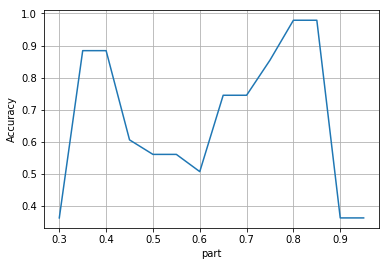

In [14]:
plt.plot([i[0] for i in runs_more_part_intersection], [i[1]['Accuracy'] for i in runs_more_part_intersection])
plt.xlabel('part')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [15]:
max_index = np.argmax([i[1]['Accuracy'] for i in runs_more_part_intersection])
for k, v in runs_more_part_intersection[max_index][1].items():
    print('{}: {:.4f}'.format(k, v))

True Positive: 58.5000
True Negative: 34.5000
False Positive: 0.0000
False Negative: 2.0000
True Positive Rate: 0.9673
True Negative Rate: 1.0000
False Positive Rate: 0.0000
Negative Predictive Value: 0.9455
False Discovery Rate: 0.0000
Accuracy: 0.9789
Precision: 1.0000
Recall: 0.9673


Тоже самое, но считаем пересечение только по 1 (ожидаем, очевидно, тоже самое)

In [16]:
def intersect(a, b):
    cnt = 0
    for x, y in zip(a, b):
        if x == y == 1:
            cnt += 1
    return cnt
    
def get_more_part_intersection_classifier(intersection_part):
    
    def classify_more_part_intersection(X_train_pos, X_train_neg, X_test):
        y_pred = []
        d = X_train_pos.shape[1] / 3
        for test_obj in X_test:
            pos_close = 0
            neg_close = 0
            for x in X_train_pos:
                if intersect(test_obj, x) > intersection_part * d:
                    pos_close += 1

            for x in X_train_neg:
                if intersect(test_obj, x) > intersection_part * d:
                    neg_close += 1
            pos_close /= float(len(X_train_pos))
            neg_close /= float(len(X_train_neg))
            if (pos_close > neg_close):
                y_pred.append(1)
            else:
                y_pred.append(0)
        return np.array(y_pred)
    return classify_more_part_intersection

In [17]:
runs_more_part_intersection = []
for i in np.arange(0.3, 1., 0.05):
    print('-' * 100)
    print('Part = {}'.format(i))
    runs_more_part_intersection.append((i, run_all(get_more_part_intersection_classifier(i), splitted_data)))
    for k, v in runs_more_part_intersection[-1][1].items():
        print('{}: {:.4f}'.format(k, v))
    print()

----------------------------------------------------------------------------------------------------
Part = 0.3
True Positive: 32.6000
True Negative: 20.7000
False Positive: 13.8000
False Negative: 27.9000
True Positive Rate: 0.5386
True Negative Rate: 0.5999
False Positive Rate: 0.2293
Negative Predictive Value: 0.4244
False Discovery Rate: 0.2962
Accuracy: 0.5611
Precision: 0.7038
Recall: 0.5386

----------------------------------------------------------------------------------------------------
Part = 0.35
True Positive: 29.1000
True Negative: 19.1000
False Positive: 15.4000
False Negative: 31.4000
True Positive Rate: 0.4800
True Negative Rate: 0.5527
False Positive Rate: 0.2555
Negative Predictive Value: 0.3762
False Discovery Rate: 0.3460
Accuracy: 0.5074
Precision: 0.6540
Recall: 0.4800

----------------------------------------------------------------------------------------------------
Part = 0.39999999999999997
True Positive: 29.1000
True Negative: 19.1000
False Positive: 15.40

/Users/boyalex/new_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


True Positive: 0.0000
True Negative: 34.5000
False Positive: 0.0000
False Negative: 60.5000
True Positive Rate: 0.0000
True Negative Rate: 1.0000
False Positive Rate: 0.0000
Negative Predictive Value: 0.3632
False Discovery Rate: nan
Accuracy: 0.3632
Precision: 0.0000
Recall: 0.0000

----------------------------------------------------------------------------------------------------
Part = 0.8499999999999999
True Positive: 0.0000
True Negative: 34.5000
False Positive: 0.0000
False Negative: 60.5000
True Positive Rate: 0.0000
True Negative Rate: 1.0000
False Positive Rate: 0.0000
Negative Predictive Value: 0.3632
False Discovery Rate: nan
Accuracy: 0.3632
Precision: 0.0000
Recall: 0.0000

----------------------------------------------------------------------------------------------------
Part = 0.8999999999999999
True Positive: 0.0000
True Negative: 34.5000
False Positive: 0.0000
False Negative: 60.5000
True Positive Rate: 0.0000
True Negative Rate: 1.0000
False Positive Rate: 0.0000
Ne

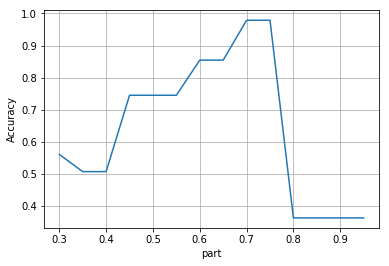

In [18]:
plt.plot([i[0] for i in runs_more_part_intersection], [i[1]['Accuracy'] for i in runs_more_part_intersection])
plt.xlabel('part')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [19]:
max_index = np.argmax([i[1]['Accuracy'] for i in runs_more_part_intersection])
for k, v in runs_more_part_intersection[max_index][1].items():
    print('{}: {:.4f}'.format(k, v))

True Positive: 58.5000
True Negative: 34.5000
False Positive: 0.0000
False Negative: 2.0000
True Positive Rate: 0.9673
True Negative Rate: 1.0000
False Positive Rate: 0.0000
Negative Predictive Value: 0.9455
False Discovery Rate: 0.0000
Accuracy: 0.9789
Precision: 1.0000
Recall: 0.9673


### Лучший результат: Accuracy 0.9832 при размере пересечения в 80% фичей

# По генераторам

Будем считать $intersect(a, b) = a' \cap b'$. 

Первый признак -- будем считать $|a' \cap g^{+}|$ и $|a' \cap g^{-}|$ по всем положительным и отрицательным примером, затем полученные значения агрегировать (мин, макс, среднее, медиана, 90квантиль), если больше на положительных примерах - предсказываем 1, и наоборот.

In [20]:
def intersect(a, b):
    return [i for i in range(len(a)) if a[i] == b[i] == 1]

def get_intersection_power_classifier(aggr_func):
    def intersection_power_classifier(X_train_pos, X_train_neg, X_test):
        d = X_test.shape[1]
        y_pred = []
        for x in X_test:
            powers_pos = []
            powers_neg = []

            for pos in X_train_pos:
                intersection = intersect(x, pos)
                powers_pos.append(len(intersection))
            for neg in X_train_neg:
                intersection = intersect(x, neg)
                powers_neg.append(len(intersection))
                
            pos_mean = aggr_func(np.array(powers_pos))
            neg_mean = aggr_func(np.array(powers_neg))
            if pos_mean > neg_mean:
                y_pred.append(1)
            else:
                y_pred.append(0)
        return np.array(y_pred)
    return intersection_power_classifier

Перебираем аггрегатные функции

In [21]:
for aggr_func, name in zip(
    [np.min, np.max, np.mean, np.median, lambda i: np.percentile(i, 90)],
    ['min', 'max', 'mean', 'median', 'q90']
):
    print('Aggregate function:', name) 
    current_run = run_all(get_intersection_power_classifier(aggr_func), splitted_data)
    for k, v in current_run.items():
        print('\t{}: {:.4f}'.format(k, v))
    print()

Aggregate function: min
	True Positive: 19.7000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 40.8000
	True Positive Rate: 0.3249
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.4594
	False Discovery Rate: 0.0000
	Accuracy: 0.5705
	Precision: 1.0000
	Recall: 0.3249

Aggregate function: max
	True Positive: 11.4000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 49.1000
	True Positive Rate: 0.1886
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.4130
	False Discovery Rate: 0.0000
	Accuracy: 0.4832
	Precision: 1.0000
	Recall: 0.1886

Aggregate function: mean
	True Positive: 38.4000
	True Negative: 23.8000
	False Positive: 10.7000
	False Negative: 22.1000
	True Positive Rate: 0.6350
	True Negative Rate: 0.6896
	False Positive Rate: 0.1777
	Negative Predictive Value: 0.5183
	False Discovery Rate: 0.2176
	Accuracy: 0.6547
	Precision: 0.7824
	Recall: 0.6350

Aggregate function: med

Лучше всего - взятие среднего, Accuracy: 0.6547

Теперь будем поддержки(supp) на положительных объектах, на отрицательных, агрегировать и сравнивать.

In [22]:
def count_subset_in_data(a, features):
    if len(features):
        return np.sum(np.all(a.T[np.array(features)].T == 1, axis=1))
    else:
        return 0

def get_supp_classifier(aggr_func):
    def supp_classifier(X_train_pos, X_train_neg, X_test):
        y_pred = []
        for x in X_test:
            supp_pos = []
            supp_neg = []
        
            for pos in X_train_pos:
                intersection = intersect(x, pos)
                supp_pos.append(count_subset_in_data(X_train_pos, intersection))
            for neg in X_train_neg:
                intersection = intersect(x, neg)
                supp_neg.append(count_subset_in_data(X_train_neg, intersection))

            pos_mean = aggr_func(np.array(supp_pos) / len(X_train_pos))
            neg_mean = aggr_func(np.array(supp_neg) / len(X_train_neg))
            if pos_mean > neg_mean:
                y_pred.append(1)
            else:
                y_pred.append(0)
        return np.array(y_pred)
    return supp_classifier

In [23]:
for aggr_func, name in zip(
    [np.min, np.max, np.mean, np.median, lambda i: np.percentile(i, 90)],
    ['min', 'max', 'mean', 'median', 'q90']
):
    print('Aggregate function:', name) 
    current_run = run_all(get_supp_classifier(aggr_func), splitted_data)
    for k, v in current_run.items():
        print('\t{}: {:.4f}'.format(k, v))
    print()

Aggregate function: min
	True Positive: 19.7000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 40.8000
	True Positive Rate: 0.3249
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.4594
	False Discovery Rate: 0.0000
	Accuracy: 0.5705
	Precision: 1.0000
	Recall: 0.3249

Aggregate function: max
	True Positive: 44.3000
	True Negative: 21.9000
	False Positive: 12.6000
	False Negative: 16.2000
	True Positive Rate: 0.7323
	True Negative Rate: 0.6330
	False Positive Rate: 0.2088
	Negative Predictive Value: 0.5758
	False Discovery Rate: 0.2218
	Accuracy: 0.6968
	Precision: 0.7782
	Recall: 0.7323

Aggregate function: mean
	True Positive: 59.5000
	True Negative: 32.4000
	False Positive: 2.1000
	False Negative: 1.0000
	True Positive Rate: 0.9835
	True Negative Rate: 0.9397
	False Positive Rate: 0.0352
	Negative Predictive Value: 0.9705
	False Discovery Rate: 0.0339
	Accuracy: 0.9674
	Precision: 0.9661
	Recall: 0.9835

Aggregate function: medi

Теперь будем считать и агрегировать достоверности(conf)

In [24]:
def get_conf_classifier(aggr_func):
    def conf_classifier(X_train_pos, X_train_neg, X_test):
        y_pred = []
        for x in X_test:
            conf_pos = []
            conf_neg = []
        
            for pos in X_train_pos:
                intersection = intersect(x, pos)
                conf_pos.append(count_subset_in_data(X_train_neg, intersection))
            for neg in X_train_neg:
                intersection = intersect(x, neg)
                conf_neg.append(count_subset_in_data(X_train_pos, intersection))

            pos_mean = aggr_func(np.array(conf_pos) / len(X_train_neg))
            neg_mean = aggr_func(np.array(conf_neg) / len(X_train_pos))
            if pos_mean < neg_mean:
                y_pred.append(1)
            else:
                y_pred.append(0)
        return np.array(y_pred)
    return conf_classifier

In [25]:
for aggr_func, name in zip(
    [np.min, np.max, np.mean, np.median, lambda i: np.percentile(i, 90)],
    ['min', 'max', 'mean', 'median', 'q90']
):
    print('Aggregate function:', name) 
    current_run = run_all(get_conf_classifier(aggr_func), splitted_data)
    for k, v in current_run.items():
        print('\t{}: {:.4f}'.format(k, v))
    print()

Aggregate function: min


/Users/boyalex/new_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


	True Positive: 0.0000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 60.5000
	True Positive Rate: 0.0000
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.3632
	False Discovery Rate: nan
	Accuracy: 0.3632
	Precision: 0.0000
	Recall: 0.0000

Aggregate function: max
	True Positive: 45.3000
	True Negative: 18.2000
	False Positive: 16.3000
	False Negative: 15.2000
	True Positive Rate: 0.7476
	True Negative Rate: 0.5242
	False Positive Rate: 0.2697
	Negative Predictive Value: 0.5481
	False Discovery Rate: 0.2662
	Accuracy: 0.6684
	Precision: 0.7338
	Recall: 0.7476

Aggregate function: mean
	True Positive: 36.3000
	True Negative: 21.1000
	False Positive: 13.4000
	False Negative: 24.2000
	True Positive Rate: 0.6004
	True Negative Rate: 0.6108
	False Positive Rate: 0.2224
	Negative Predictive Value: 0.4638
	False Discovery Rate: 0.2677
	Accuracy: 0.6042
	Precision: 0.7323
	Recall: 0.6004

Aggregate function: median
	True Positive: 38.4000

Лучший результат - взятие среднего, Accuracy: 0.6747

Будем предсказывать 1, если агрегация достоверностей $|(g \cap g^{+})^{-}|$ меньше порога

In [26]:
def get_pos_thr_conf_classifier(aggr_func, thr):
    def pos_thr_conf_classifier(X_train_pos, X_train_neg, X_test):
        y_pred = []
        for x in X_test:
            conf_pos = []
        
            for pos in X_train_pos:
                intersection = intersect(x, pos)
                conf_pos.append(count_subset_in_data(X_train_neg, intersection))

            pos_mean = aggr_func(np.array(conf_pos) / len(X_train_neg))
            if pos_mean < thr:
                y_pred.append(1)
            else:
                y_pred.append(0)
        return np.array(y_pred)
    return pos_thr_conf_classifier

In [27]:
for thr in [0.05, 0.1, 0.15]:
    for aggr_func, name in zip(
        [np.min, np.max, np.mean, np.median, lambda i: np.percentile(i, 90)],
        ['min', 'max', 'mean', 'median', 'q90']
    ):
        print('Aggregate function:', name, '| thr:', thr) 
        current_run = run_all(get_pos_thr_conf_classifier(aggr_func, thr), splitted_data)
        for k, v in current_run.items():
            print('\t{}: {:.4f}'.format(k, v))
        print()

Aggregate function: min | thr: 0.05


/Users/boyalex/new_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


	True Positive: 60.5000
	True Negative: 0.0000
	False Positive: 34.5000
	False Negative: 0.0000
	True Positive Rate: 1.0000
	True Negative Rate: 0.0000
	False Positive Rate: 0.5733
	Negative Predictive Value: nan
	False Discovery Rate: 0.3632
	Accuracy: 0.6368
	Precision: 0.6368
	Recall: 1.0000

Aggregate function: max | thr: 0.05


/Users/boyalex/new_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


	True Positive: 0.0000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 60.5000
	True Positive Rate: 0.0000
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.3632
	False Discovery Rate: nan
	Accuracy: 0.3632
	Precision: 0.0000
	Recall: 0.0000

Aggregate function: mean | thr: 0.05
	True Positive: 1.6000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 58.9000
	True Positive Rate: 0.0264
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.3694
	False Discovery Rate: 0.0000
	Accuracy: 0.3800
	Precision: 1.0000
	Recall: 0.0264

Aggregate function: median | thr: 0.05
	True Positive: 51.5000
	True Negative: 17.0000
	False Positive: 17.5000
	False Negative: 9.0000
	True Positive Rate: 0.8513
	True Negative Rate: 0.4940
	False Positive Rate: 0.2913
	Negative Predictive Value: 0.6629
	False Discovery Rate: 0.2526
	Accuracy: 0.7211
	Precision: 0.7474
	Recall: 0.8513

Aggregate function: q90 | 

In [28]:
for thr in np.linspace(0, 0.1, 5):
    for aggr_func, name in zip(
        [np.min, np.max, np.mean, np.median, lambda i: np.percentile(i, 90)],
        ['min', 'max', 'mean', 'median', 'q90']
    ):
        print('Aggregate function:', name, '| thr:', thr) 
        current_run = run_all(get_pos_thr_conf_classifier(aggr_func, thr), splitted_data)
        for k, v in current_run.items():
            print('\t{}: {:.4f}'.format(k, v))
        print()

Aggregate function: min | thr: 0.0


/Users/boyalex/new_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


	True Positive: 0.0000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 60.5000
	True Positive Rate: 0.0000
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.3632
	False Discovery Rate: nan
	Accuracy: 0.3632
	Precision: 0.0000
	Recall: 0.0000

Aggregate function: max | thr: 0.0
	True Positive: 0.0000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 60.5000
	True Positive Rate: 0.0000
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.3632
	False Discovery Rate: nan
	Accuracy: 0.3632
	Precision: 0.0000
	Recall: 0.0000

Aggregate function: mean | thr: 0.0
	True Positive: 0.0000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 60.5000
	True Positive Rate: 0.0000
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.3632
	False Discovery Rate: nan
	Accuracy: 0.3632
	Precision: 0.0000
	Recall: 0.0000

Aggregate function: median | thr: 0.0


/Users/boyalex/new_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


	True Positive: 60.5000
	True Negative: 0.0000
	False Positive: 34.5000
	False Negative: 0.0000
	True Positive Rate: 1.0000
	True Negative Rate: 0.0000
	False Positive Rate: 0.5733
	Negative Predictive Value: nan
	False Discovery Rate: 0.3632
	Accuracy: 0.6368
	Precision: 0.6368
	Recall: 1.0000

Aggregate function: max | thr: 0.025
	True Positive: 0.0000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 60.5000
	True Positive Rate: 0.0000
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.3632
	False Discovery Rate: nan
	Accuracy: 0.3632
	Precision: 0.0000
	Recall: 0.0000

Aggregate function: mean | thr: 0.025
	True Positive: 0.0000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 60.5000
	True Positive Rate: 0.0000
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.3632
	False Discovery Rate: nan
	Accuracy: 0.3632
	Precision: 0.0000
	Recall: 0.0000

Aggregate function: median | thr: 

#### Лучший результат - медиана, порог $0.05$, Accuracy: $0.7389$

Аналогично предыдущему, но считаем достоверности $|(g \cap g^{-})^{+}|$

In [64]:
def get_neg_thr_conf_classifier(aggr_func, thr):
    def neg_thr_conf_classifier(X_train_pos, X_train_neg, X_test):
        y_pred = []
        for x in X_test:
            conf_neg = []

            for neg in X_train_neg:
                intersection = intersect(x, neg)
                conf_neg.append(count_subset_in_data(X_train_pos, intersection))

            neg_mean = aggr_func(np.array(conf_neg) / len(X_train_pos))
            if thr > neg_mean:
                y_pred.append(0)
            else:
                y_pred.append(1)
        return np.array(y_pred)
    return neg_thr_conf_classifier

In [65]:
for thr in np.arange(0.3, 1.1, 0.1):
    for aggr_func, name in zip(
        [np.min, np.max, np.mean, np.median, lambda i: np.percentile(i, 90)],
        ['min', 'max', 'mean', 'median', 'q90']
    ):
        print('Aggregate function:', name, '| thr:', thr) 
        current_run = run_all(get_neg_thr_conf_classifier(aggr_func, thr), splitted_data)
        for k, v in current_run.items():
            print('\t{}: {:.4f}'.format(k, v))
        print()

Aggregate function: min | thr: 0.3


/Users/boyalex/new_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/boyalex/new_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


	True Positive: 0.0000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 60.5000
	True Positive Rate: 0.0000
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.3632
	False Discovery Rate: nan
	Accuracy: 0.3632
	Precision: 0.0000
	Recall: 0.0000

Aggregate function: max | thr: 0.3


/Users/boyalex/new_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


	True Positive: 60.5000
	True Negative: 2.2000
	False Positive: 32.3000
	False Negative: 0.0000
	True Positive Rate: 1.0000
	True Negative Rate: 0.0613
	False Positive Rate: 0.5360
	Negative Predictive Value: nan
	False Discovery Rate: 0.3468
	Accuracy: 0.6600
	Precision: 0.6532
	Recall: 1.0000

Aggregate function: mean | thr: 0.3
	True Positive: 0.0000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 60.5000
	True Positive Rate: 0.0000
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.3632
	False Discovery Rate: nan
	Accuracy: 0.3632
	Precision: 0.0000
	Recall: 0.0000

Aggregate function: median | thr: 0.3
	True Positive: 0.0000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 60.5000
	True Positive Rate: 0.0000
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.3632
	False Discovery Rate: nan
	Accuracy: 0.3632
	Precision: 0.0000
	Recall: 0.0000

Aggregate function: q90 | thr: 0.3


	True Positive: 0.0000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 60.5000
	True Positive Rate: 0.0000
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.3632
	False Discovery Rate: nan
	Accuracy: 0.3632
	Precision: 0.0000
	Recall: 0.0000

Aggregate function: mean | thr: 0.8000000000000003
	True Positive: 0.0000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 60.5000
	True Positive Rate: 0.0000
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.3632
	False Discovery Rate: nan
	Accuracy: 0.3632
	Precision: 0.0000
	Recall: 0.0000

Aggregate function: median | thr: 0.8000000000000003
	True Positive: 0.0000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 60.5000
	True Positive Rate: 0.0000
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.3632
	False Discovery Rate: nan
	Accuracy: 0.3632
	Precision: 0.0000
	Recall: 0.0000

Aggre

#### Лучшее значение - взятие максимума при пороге $0.6$, Accuracy: $0.7789$

# Вместо сравнений вставим пороги, добавим неуверенное предсказние

In [31]:
def run_thr(classify, inp):
    (X_train, y_train), (X_test, y_test) = inp
    X_train_pos = X_train[y_train == 1]
    X_train_neg = X_train[y_train == 0]
    y_pred = classify(X_train_pos, X_train_neg, X_test)
    cv_res = {
        "positive_positive": 0,
        "positive_negative": 0,
        "negative_positive": 0,
        "negative_negative": 0,
        "contradictory": 0,
        "total": 0,
    }
    cv_res['total'] += len(y_test)
    for i, j in zip(y_test, y_pred):
        if (i == 0) and (j == 0):
            cv_res['negative_negative'] += 1
        if (i == 1) and (j == 0):
            cv_res['positive_negative'] += 1
        if (i == 1) and (j == 1):
            cv_res['positive_positive'] += 1
        if (i == 0) and (j == 1):
            cv_res['negative_positive'] += 1
        if (j == -1):
            cv_res['contradictory'] += 1
    
    return cv_res


def run_all_thr(classify, index_range=range(1, 11)):
    cv_res = defaultdict(float)
    for i in index_range:
        for k, v in run_thr(classify, i).items():
            cv_res[k] += v
    metrics = {
        'True  Positive': cv_res["positive_positive"] / cv_res['total'],
        'True  Negative': cv_res["negative_negative"] / cv_res['total'],
        'False Positive': cv_res["negative_positive"] / cv_res['total'],
        'False Negative': cv_res["positive_negative"] / cv_res['total'],
        'Contradictory': cv_res["contradictory"] / cv_res['total'],
        'Accuracy': (cv_res["positive_positive"] + cv_res["negative_negative"]) / cv_res['total'],
        'Total': cv_res['total']
    }
    return metrics

In [32]:
def get_supp_classifier_thr(aggr_func, thr):
    def supp_classifier_thr(X_train_pos, X_train_neg, X_test):
        y_pred = []
        for x in X_test:
            supp_pos = []
            supp_neg = []
        
            for pos in X_train_pos:
                intersection = intersect(x, pos)
                supp_pos.append(count_subset_in_data(X_train_pos, intersection))
            for neg in X_train_neg:
                intersection = intersect(x, neg)
                supp_neg.append(count_subset_in_data(X_train_neg, intersection))

            pos_mean = aggr_func(np.array(supp_pos) / len(X_train_pos))
            neg_mean = aggr_func(np.array(supp_neg) / len(X_train_neg))
            
            def score(pos, neg):
                return 1. * pos / (neg + 1.)
            if score(pos_mean, neg_mean) > thr:
                y_pred.append(1)
            elif score(neg_mean, pos_mean) > thr:
                y_pred.append(0)
            else:
                y_pred.append(-1)
        return np.array(y_pred)
    return supp_classifier_thr

In [33]:
for thr in np.linspace(0, 1, 10):
    for aggr_func, name in zip(
        [np.min, np.max, np.mean, np.median, lambda i: np.percentile(i, 90)],
        ['min', 'max', 'mean', 'median', 'q90']
    ):
        print('Aggregate function:', name, '| thr:', thr) 
        current_run = run_all_thr(get_supp_classifier_thr(aggr_func, thr), splitted_data)
        for k, v in current_run.items():
            print('\t{}: {:.4f}'.format(k, v))
        print()

Aggregate function: min | thr: 0.0
	True  Positive: 0.2074
	True  Negative: 0.1274
	False Positive: 0.0147
	False Negative: 0.0000
	Contradictory: 0.6505
	Accuracy: 0.3347
	Total: 950.0000

Aggregate function: max | thr: 0.0
	True  Positive: 0.6368
	True  Negative: 0.0000
	False Positive: 0.3632
	False Negative: 0.0000
	Contradictory: 0.0000
	Accuracy: 0.6368
	Total: 950.0000

Aggregate function: mean | thr: 0.0
	True  Positive: 0.6368
	True  Negative: 0.0000
	False Positive: 0.3632
	False Negative: 0.0000
	Contradictory: 0.0000
	Accuracy: 0.6368
	Total: 950.0000

Aggregate function: median | thr: 0.0
	True  Positive: 0.6368
	True  Negative: 0.0000
	False Positive: 0.3632
	False Negative: 0.0000
	Contradictory: 0.0000
	Accuracy: 0.6368
	Total: 950.0000

Aggregate function: q90 | thr: 0.0
	True  Positive: 0.6368
	True  Negative: 0.0000
	False Positive: 0.3632
	False Negative: 0.0000
	Contradictory: 0.0000
	Accuracy: 0.6368
	Total: 950.0000

Aggregate function: min | thr: 0.1111111111111

	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

Aggregate function: max | thr: 0.8888888888888888
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

Aggregate function: mean | thr: 0.8888888888888888
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

Aggregate function: median | thr: 0.8888888888888888
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

Aggregate function: q90 | thr: 0.8888888888888888
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

Aggregate function: m

In [34]:
def get_conf_classifier_thr(aggr_func, thr):
    def conf_classifier_thr(X_train_pos, X_train_neg, X_test):
        y_pred = []
        for x in X_test:
            conf_pos = []
            conf_neg = []
        
            for pos in X_train_pos:
                intersection = intersect(x, pos)
                conf_pos.append(count_subset_in_data(X_train_neg, intersection))
            for neg in X_train_neg:
                intersection = intersect(x, neg)
                conf_neg.append(count_subset_in_data(X_train_pos, intersection))

            pos_mean = aggr_func(np.array(conf_pos) / len(X_train_neg))
            neg_mean = aggr_func(np.array(conf_neg) / len(X_train_pos))
            if (pos_mean < thr) and (neg_mean > thr):
                y_pred.append(1)
            elif (pos_mean > thr) and (neg_mean < thr):
                y_pred.append(0)
            else:
                y_pred.append(-1)
        return np.array(y_pred)
    return conf_classifier_thr

In [35]:
for thr in np.linspace(0.05, 0.3, 10):
    for aggr_func, name in zip(
        [np.min, np.max, np.mean, np.median, lambda i: np.percentile(i, 90)],
        ['min', 'max', 'mean', 'median', 'q90']
    ):
        print('Aggregate function:', name, '|, thr:', thr) 
        current_run = run_all_thr(get_conf_classifier_thr(aggr_func, thr), splitted_data)
        for k, v in current_run.items():
            print('\t{}: {:.4f}'.format(k, v))
        print()

Aggregate function: min |, thr: 0.05
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

Aggregate function: max |, thr: 0.05
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

Aggregate function: mean |, thr: 0.05
	True  Positive: 0.0168
	True  Negative: 0.0632
	False Positive: 0.0000
	False Negative: 0.0147
	Contradictory: 0.9053
	Accuracy: 0.0800
	Total: 950.0000

Aggregate function: median |, thr: 0.05
	True  Positive: 0.2632
	True  Negative: 0.1779
	False Positive: 0.0400
	False Negative: 0.0926
	Contradictory: 0.4263
	Accuracy: 0.4411
	Total: 950.0000

Aggregate function: q90 |, thr: 0.05
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

Aggregate function: min |, thr: 0.07

	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

Aggregate function: max |, thr: 0.2722222222222222
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

Aggregate function: mean |, thr: 0.2722222222222222
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

Aggregate function: median |, thr: 0.2722222222222222
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

Aggregate function: q90 |, thr: 0.2722222222222222
	True  Positive: 0.2126
	True  Negative: 0.1126
	False Positive: 0.0958
	False Negative: 0.2000
	Contradictory: 0.3789
	Accuracy: 0.3253
	Total: 950.0000

Aggregate functio

In [36]:
for thr in np.linspace(0.1, 0.4, 20):
    aggr_func = np.mean
    name = 'mean'
    print('Aggregate function:', name, '|, thr:', thr) 
    current_run = run_all_thr(get_conf_classifier_thr(aggr_func, thr), splitted_data)
    for k, v in current_run.items():
        print('\t{}: {:.4f}'.format(k, v))
    print()

Aggregate function: mean |, thr: 0.1
	True  Positive: 0.2316
	True  Negative: 0.1389
	False Positive: 0.0358
	False Negative: 0.0926
	Contradictory: 0.5011
	Accuracy: 0.3705
	Total: 950.0000

Aggregate function: mean |, thr: 0.11578947368421054
	True  Positive: 0.0737
	True  Negative: 0.0674
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 0.8589
	Accuracy: 0.1411
	Total: 950.0000

Aggregate function: mean |, thr: 0.13157894736842107
	True  Positive: 0.0211
	True  Negative: 0.0053
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 0.9737
	Accuracy: 0.0263
	Total: 950.0000

Aggregate function: mean |, thr: 0.1473684210526316
	True  Positive: 0.0000
	True  Negative: 0.0032
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 0.9968
	Accuracy: 0.0032
	Total: 950.0000

Aggregate function: mean |, thr: 0.1631578947368421
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0

In [37]:
def get_conf_classifier_thr2(aggr_func, thr1, thr2):
    def conf_classifier_thr2(X_train_pos, X_train_neg, X_test):
        y_pred = []
        for x in X_test:
            conf_pos = []
            conf_neg = []
        
            for pos in X_train_pos:
                intersection = intersect(x, pos)
                conf_pos.append(count_subset_in_data(X_train_neg, intersection))
            for neg in X_train_neg:
                intersection = intersect(x, neg)
                conf_neg.append(count_subset_in_data(X_train_pos, intersection))

            pos_mean = aggr_func(np.array(conf_pos) / len(X_train_neg))
            neg_mean = aggr_func(np.array(conf_neg) / len(X_train_pos))
            if (pos_mean < thr1) and (neg_mean > thr2):
                y_pred.append(1)
            elif (pos_mean > thr2) and (neg_mean < thr1):
                y_pred.append(0)
            else:
                y_pred.append(-1)
        return np.array(y_pred)
    return conf_classifier_thr2

In [38]:
for thr1 in np.linspace(0.05, 0.25, 7):
    for thr2 in np.linspace(0.05, 0.25, 7):
        aggr_func = np.mean
        name = 'mean'
        print('Aggregate function:', name, '|, thr1:', thr1, '| thr2:', thr2) 
        current_run = run_all_thr(get_conf_classifier_thr2(aggr_func, thr1, thr2), splitted_data)
        for k, v in current_run.items():
            print('\t{}: {:.4f}'.format(k, v))
        print()

Aggregate function: mean |, thr1: 0.05 | thr2: 0.05
	True  Positive: 0.0168
	True  Negative: 0.0632
	False Positive: 0.0000
	False Negative: 0.0147
	Contradictory: 0.9053
	Accuracy: 0.0800
	Total: 950.0000

Aggregate function: mean |, thr1: 0.05 | thr2: 0.08333333333333334
	True  Positive: 0.0168
	True  Negative: 0.0632
	False Positive: 0.0000
	False Negative: 0.0147
	Contradictory: 0.9053
	Accuracy: 0.0800
	Total: 950.0000

Aggregate function: mean |, thr1: 0.05 | thr2: 0.11666666666666667
	True  Positive: 0.0116
	True  Negative: 0.0495
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 0.9389
	Accuracy: 0.0611
	Total: 950.0000

Aggregate function: mean |, thr1: 0.05 | thr2: 0.15000000000000002
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

Aggregate function: mean |, thr1: 0.05 | thr2: 0.18333333333333335
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Posit

	True  Positive: 0.3800
	True  Negative: 0.1832
	False Positive: 0.1611
	False Negative: 0.2263
	Contradictory: 0.0495
	Accuracy: 0.5632
	Total: 950.0000

Aggregate function: mean |, thr1: 0.21666666666666667 | thr2: 0.11666666666666667
	True  Positive: 0.0695
	True  Negative: 0.0600
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 0.8705
	Accuracy: 0.1295
	Total: 950.0000

Aggregate function: mean |, thr1: 0.21666666666666667 | thr2: 0.15000000000000002
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

Aggregate function: mean |, thr1: 0.21666666666666667 | thr2: 0.18333333333333335
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

Aggregate function: mean |, thr1: 0.21666666666666667 | thr2: 0.21666666666666667
	True  Positive: 0.0000
	True  Negative: 0.0000
	Fal

### Лучшее - thr1 $0.15$, thr2 $0.05$, Accuracy $0.7368$

In [39]:
def get_supp_classifier_thr(aggr_func, thr):
    def supp_classifier_thr(X_train_pos, X_train_neg, X_test):
        y_pred = []
        for x in X_test:
            supp_pos = []
            supp_neg = []
        
            for pos in X_train_pos:
                intersection = intersect(x, pos)
                supp_pos.append(count_subset_in_data(X_train_pos, intersection))
            for neg in X_train_neg:
                intersection = intersect(x, neg)
                supp_neg.append(count_subset_in_data(X_train_neg, intersection))

            pos_mean = aggr_func(np.array(supp_pos) / len(X_train_pos))
            neg_mean = aggr_func(np.array(supp_neg) / len(X_train_neg))
            if pos_mean - neg_mean > thr:
                y_pred.append(1)
            elif neg_mean - pos_mean > thr:
                y_pred.append(0)
            else:
                y_pred.append(-1)
        return np.array(y_pred)
    return supp_classifier_thr

In [40]:
run_all_thr(get_supp_classifier_thr(np.median, 0), splitted_data)

{'True  Positive': 0.6073684210526316,
 'True  Negative': 0.3631578947368421,
 'False Positive': 0.0,
 'False Negative': 0.029473684210526315,
 'Contradictory': 0.0,
 'Accuracy': 0.9705263157894737,
 'Total': 950.0}

In [41]:
for thr in np.linspace(0, 0.1, 5):
    for aggr_func, name in zip(
        [np.mean, np.median, lambda i: np.percentile(i, 90)],
        ['mean', 'median', 'q90']
    ):
        print('Aggregate function:', name, '| thr:', thr) 
        current_run = run_all_thr(get_supp_classifier_thr(aggr_func, thr), splitted_data)
        for k, v in current_run.items():
            print('\t{}: {:.4f}'.format(k, v))
        print()

Aggregate function: mean | thr: 0.0
	True  Positive: 0.6263
	True  Negative: 0.3411
	False Positive: 0.0221
	False Negative: 0.0105
	Contradictory: 0.0000
	Accuracy: 0.9674
	Total: 950.0000

Aggregate function: median | thr: 0.0
	True  Positive: 0.6074
	True  Negative: 0.3632
	False Positive: 0.0000
	False Negative: 0.0295
	Contradictory: 0.0000
	Accuracy: 0.9705
	Total: 950.0000

Aggregate function: q90 | thr: 0.0
	True  Positive: 0.3389
	True  Negative: 0.2358
	False Positive: 0.1274
	False Negative: 0.2979
	Contradictory: 0.0000
	Accuracy: 0.5747
	Total: 950.0000

Aggregate function: mean | thr: 0.025
	True  Positive: 0.0116
	True  Negative: 0.0653
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 0.9232
	Accuracy: 0.0768
	Total: 950.0000

Aggregate function: median | thr: 0.025
	True  Positive: 0.0011
	True  Negative: 0.0432
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 0.9558
	Accuracy: 0.0442
	Total: 950.0000

Aggregate function: q90 | thr: 0.025
	

In [42]:
def get_conf_classifier(aggr_func):
    def conf_classifier(X_train_pos, X_train_neg, X_test):
        y_pred = []
        for x in X_test:
            conf_pos = []
            conf_neg = []
        
            for pos in X_train_pos:
                intersection = intersect(x, pos)
                conf_pos.append(count_subset_in_data(X_train_neg, intersection))
            for neg in X_train_neg:
                intersection = intersect(x, neg)
                conf_neg.append(count_subset_in_data(X_train_pos, intersection))

            pos_mean = aggr_func(np.array(conf_pos) / len(X_train_neg))
            neg_mean = aggr_func(np.array(conf_neg) / len(X_train_pos))
            if pos_mean < neg_mean:
                y_pred.append(1)
            else:
                y_pred.append(0)
        return np.array(y_pred)
    return conf_classifier

In [43]:
for aggr_func, name in zip(
    [np.min, np.max, np.mean, np.median, lambda i: np.percentile(i, 90)],
    ['min', 'max', 'mean', 'median', 'q90']
):
    print('Aggregate function:', name) 
    current_run = run_all(get_conf_classifier(aggr_func), splitted_data)
    for k, v in current_run.items():
        print('\t{}: {:.4f}'.format(k, v))
    print()

Aggregate function: min


/Users/boyalex/new_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


	True Positive: 0.0000
	True Negative: 34.5000
	False Positive: 0.0000
	False Negative: 60.5000
	True Positive Rate: 0.0000
	True Negative Rate: 1.0000
	False Positive Rate: 0.0000
	Negative Predictive Value: 0.3632
	False Discovery Rate: nan
	Accuracy: 0.3632
	Precision: 0.0000
	Recall: 0.0000

Aggregate function: max
	True Positive: 45.3000
	True Negative: 18.2000
	False Positive: 16.3000
	False Negative: 15.2000
	True Positive Rate: 0.7476
	True Negative Rate: 0.5242
	False Positive Rate: 0.2697
	Negative Predictive Value: 0.5481
	False Discovery Rate: 0.2662
	Accuracy: 0.6684
	Precision: 0.7338
	Recall: 0.7476

Aggregate function: mean
	True Positive: 36.3000
	True Negative: 21.1000
	False Positive: 13.4000
	False Negative: 24.2000
	True Positive Rate: 0.6004
	True Negative Rate: 0.6108
	False Positive Rate: 0.2224
	Negative Predictive Value: 0.4638
	False Discovery Rate: 0.2677
	Accuracy: 0.6042
	Precision: 0.7323
	Recall: 0.6004

Aggregate function: median
	True Positive: 38.4000

In [44]:
def get_supp_classifier_thr(aggr_func):
    def supp_classifier_thr(X_train_pos, X_train_neg, X_test):
        y_pred = []
        for x in X_test:
            supp_pos = []
            supp_neg = []
        
            for pos in X_train_pos:
                intersection = intersect(x, pos)
                supp_pos.append(count_subset_in_data(X_train_pos, intersection))
            for neg in X_train_neg:
                intersection = intersect(x, neg)
                supp_neg.append(count_subset_in_data(X_train_neg, intersection))

#             pos_mean = aggr_func(np.array(supp_pos) / len(X_train_pos))
#             neg_mean = aggr_func(np.array(supp_neg) / len(X_train_neg))
            s_pos = np.array(supp_pos) / len(X_train_pos)
            s_neg = np.array(supp_neg) / len(X_train_neg)
                        
            if np.min(s_pos) > np.max(s_neg):
                y_pred.append(1)
            elif np.min(s_neg) > np.max(s_pos):
                y_pred.append(0)
            else:
                y_pred.append(-1)
        return np.array(y_pred)
    return supp_classifier_thr

In [45]:
for aggr_func, name in zip(
    [np.mean, np.median, lambda i: np.percentile(i, 90)],
    ['mean', 'median', 'q90']
):
    print('Aggregate function:', name) 
    current_run = run_all_thr(get_supp_classifier_thr(aggr_func), splitted_data)
    for k, v in current_run.items():
        print('\t{}: {:.4f}'.format(k, v))
    print()

Aggregate function: mean
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

Aggregate function: median
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

Aggregate function: q90
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000



Рассмотрим следующее решающее правило: (supp > thr1) and (conf < thr2)

In [46]:
def count_subset_in_data_new(a, features):
    if len(features):
        return np.sum(np.all(a.T[np.array(features)].T == 1, axis=1))
    else:
        return 0

def get_supp_сonf_classifier_thr(thr1, thr2):
    def supp_conf_classifier_thr(X_train_pos, X_train_neg, X_test):
        y_pred = []
        for x in X_test:
            supp_pos = []
            supp_neg = []
            conf_pos = []
            conf_neg = []
        
            for pos in X_train_pos:
                intersection = intersect(x, pos)
                supp_pos.append(count_subset_in_data(X_train_pos, intersection))
                conf_pos.append(count_subset_in_data(X_train_neg, intersection))
            for neg in X_train_neg:
                intersection = intersect(x, neg)
                supp_neg.append(count_subset_in_data(X_train_neg, intersection))
                conf_neg.append(count_subset_in_data(X_train_pos, intersection))
            supp_pos = np.mean(np.array(supp_pos) / len(X_train_pos))
            supp_neg = np.mean(np.array(supp_neg) / len(X_train_neg))
            conf_pos = np.mean(np.array(conf_pos) / len(X_train_neg))
            conf_neg = np.mean(np.array(conf_neg) / len(X_train_pos))
              
            a = (np.mean(supp_pos) > thr1) and (np.mean(conf_pos) < thr2)
            b = (np.mean(supp_neg) > thr1) and (np.mean(conf_neg) < thr2)
            if (a and (not b)):
                y_pred.append(1)
            elif ((not a) and b):
                y_pred.append(0)
            else:
                y_pred.append(-1)
        return np.array(y_pred)
    return supp_conf_classifier_thr

In [47]:
for thr1 in [0.05, 0.1, 0.15]:
    for thr2 in [0.05, 0.1, 0.15]:
        print('thr1', thr1, '| thr2', thr2)
        current_run = run_all_thr(get_supp_сonf_classifier_thr(thr1, thr2), splitted_data)
        for k, v in current_run.items():
            print('\t{}: {:.4f}'.format(k, v))
        print()

thr1 0.05 | thr2 0.05
	True  Positive: 0.0168
	True  Negative: 0.0632
	False Positive: 0.0000
	False Negative: 0.0147
	Contradictory: 0.9053
	Accuracy: 0.0800
	Total: 950.0000

thr1 0.05 | thr2 0.1
	True  Positive: 0.2316
	True  Negative: 0.1389
	False Positive: 0.0358
	False Negative: 0.0926
	Contradictory: 0.5011
	Accuracy: 0.3705
	Total: 950.0000

thr1 0.05 | thr2 0.15
	True  Positive: 0.0000
	True  Negative: 0.0000
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 1.0000
	Accuracy: 0.0000
	Total: 950.0000

thr1 0.1 | thr2 0.05
	True  Positive: 0.0116
	True  Negative: 0.0242
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 0.9642
	Accuracy: 0.0358
	Total: 950.0000

thr1 0.1 | thr2 0.1
	True  Positive: 0.4632
	True  Negative: 0.2779
	False Positive: 0.0000
	False Negative: 0.0011
	Contradictory: 0.2579
	Accuracy: 0.7411
	Total: 950.0000

thr1 0.1 | thr2 0.15
	True  Positive: 0.5074
	True  Negative: 0.3137
	False Positive: 0.0000
	False Negative: 0.0011
	C

In [48]:
current_run = run_all_thr(get_supp_сonf_classifier_thr(0.1, 0.125), splitted_data)
for k, v in current_run.items():
    print('\t{}: {:.4f}'.format(k, v))
print()

	True  Positive: 0.5116
	True  Negative: 0.3137
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 0.1747
	Accuracy: 0.8253
	Total: 950.0000



In [49]:
current_run = run_all_thr(get_supp_сonf_classifier_thr(0.1, 0.115), splitted_data)
for k, v in current_run.items():
    print('\t{}: {:.4f}'.format(k, v))
print()

	True  Positive: 0.5168
	True  Negative: 0.3137
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 0.1695
	Accuracy: 0.8305
	Total: 950.0000



In [50]:
current_run = run_all_thr(get_supp_сonf_classifier_thr(0.1, 0.12), splitted_data)
for k, v in current_run.items():
    print('\t{}: {:.4f}'.format(k, v))
print()

	True  Positive: 0.5147
	True  Negative: 0.3137
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 0.1716
	Accuracy: 0.8284
	Total: 950.0000



In [51]:
current_run = run_all_thr(get_supp_сonf_classifier_thr(0.1, 0.11), splitted_data)
for k, v in current_run.items():
    print('\t{}: {:.4f}'.format(k, v))
print()

	True  Positive: 0.5053
	True  Negative: 0.3074
	False Positive: 0.0000
	False Negative: 0.0000
	Contradictory: 0.1874
	Accuracy: 0.8126
	Total: 950.0000



## Эксперимент 
Делим выборку на 2 части, по одной считаем все ранее использованные фичи, на них учим решающее дерево

In [52]:
def get_stacking_classifier(classifier):
    def stacking_classifier(X_train_pos, X_train_neg, X_test):
        y_pred = []
        pos_indices_first = np.arange(len(X_train_pos)//2)
        neg_indices_first = np.arange(len(X_train_neg)//2)
        X_pos_first = X_train_pos[pos_indices_first]
        X_neg_first = X_train_neg[neg_indices_first]
        X_pos_second = X_train_pos[len(pos_indices_first):]
        X_neg_second = X_train_neg[len(neg_indices_first):]
        
        features = []
        X_second = np.concatenate([X_pos_second, X_neg_second], axis=0)
        y_second = np.concatenate([np.ones((len(X_pos_second), 1)), 
                                   np.zeros((len(X_neg_second), 1))], axis=0)
        ind = np.arange(len(X_second))
        np.random.shuffle(ind)
        X_second = X_second[ind]
        y_second = y_second[ind]
        
        for i in X_second:
            sup_pos = []
            sup_neg = []
            pow_pos = []
            pow_neg = []
            conf_pos = []
            conf_neg = []
        
            for pos in X_pos_first:
                intersection = intersect(i, pos)
                pow_pos.append(len(intersection))
                sup_pos.append(count_subset_in_data(X_pos_first, intersection))
                conf_pos.append(count_subset_in_data(X_neg_first, intersection))
                
            for neg in X_train_neg:
                pow_neg.append(len(intersection))
                sup_neg.append(count_subset_in_data(X_neg_first, intersection))
                conf_neg.append(count_subset_in_data(X_pos_first, intersection))
            features.append([
                f(k) 
                for f in [np.min, np.max, np.mean, np.median, lambda _: np.percentile(_, 90)] 
                for k in [sup_pos, sup_neg, pow_pos, pow_neg, conf_pos, conf_neg]
            ])
            
        test_features = []
        for i in X_test:
            sup_pos = []
            sup_neg = []
            pow_pos = []
            pow_neg = []
            conf_pos = []
            conf_neg = []
        
            for pos in X_pos_first:
                intersection = intersect(i, pos)
                pow_pos.append(len(intersection))
                sup_pos.append(count_subset_in_data(X_pos_first, intersection))
                conf_pos.append(count_subset_in_data(X_neg_first, intersection))
                
            for neg in X_train_neg:
                pow_neg.append(len(intersection))
                sup_neg.append(count_subset_in_data(X_neg_first, intersection))
                conf_neg.append(count_subset_in_data(X_pos_first, intersection))
            test_features.append([
                f(k) 
                for f in [np.min, np.max, np.mean, np.median, lambda _: np.percentile(_, 90)] 
                for k in [sup_pos, sup_neg, pow_pos, pow_neg, conf_pos, conf_neg]
            ])
            
        features = np.array(features)
        classifier.fit(features, y_second)
        y_pred = classifier.predict(np.array(test_features))
        return np.array(y_pred)
    return stacking_classifier

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [55]:
run_all(get_stacking_classifier(DecisionTreeClassifier()), splitted_data)

{'True Positive': 57.2,
 'True Negative': 31.7,
 'False Positive': 2.8,
 'False Negative': 3.3,
 'True Positive Rate': 0.9449245962334276,
 'True Negative Rate': 0.919738521282639,
 'False Positive Rate': 0.046895965982428164,
 'Negative Predictive Value': 0.9093225821919899,
 'False Discovery Rate': 0.04627841942424787,
 'Accuracy': 0.9357894736842104,
 'Precision': 0.9537215805757523,
 'Recall': 0.9449245962334276}

In [56]:
run_all(get_stacking_classifier(LogisticRegression()), splitted_data)

/Users/boyalex/new_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boyalex/new_env/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/boyalex/new_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boyalex/new_env/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/boyalex/new_env/lib

{'True Positive': 58.8,
 'True Negative': 31.8,
 'False Positive': 2.7,
 'False Negative': 1.7,
 'True Positive Rate': 0.9723475524123331,
 'True Negative Rate': 0.9199804607157548,
 'False Positive Rate': 0.044158663329736836,
 'Negative Predictive Value': 0.9480790112241726,
 'False Discovery Rate': 0.04273629820000788,
 'Accuracy': 0.9536842105263158,
 'Precision': 0.9572637017999922,
 'Recall': 0.9723475524123331}

## Обычные классификаторы из sklearn

In [57]:
def get_sklearn_classifier(classifier):
    def stacking_classifier(X_train_pos, X_train_neg, X_test):
        y_pred = []
        X_train_all = np.concatenate([X_train_pos, X_train_neg], axis=0)
        y_train_all = np.concatenate([np.ones((len(X_train_pos), 1)), 
                                   np.zeros((len(X_train_neg), 1))], axis=0)
        ind = np.arange(len(y_train_all))
        np.random.shuffle(ind)
        
        X_train_all = X_train_all[ind]
        y_train_all = y_train_all[ind]
        
        classifier.fit(X_train_all, y_train_all)
        return classifier.predict(X_test)
    return stacking_classifier

### Логистическая регрессия

In [58]:
run_all(get_sklearn_classifier(LogisticRegression()), splitted_data)

/Users/boyalex/new_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boyalex/new_env/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/boyalex/new_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boyalex/new_env/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/boyalex/new_env/lib

{'True Positive': 60.5,
 'True Negative': 33.1,
 'False Positive': 1.4,
 'False Negative': 0.0,
 'True Positive Rate': 1.0,
 'True Negative Rate': 0.9602958928326576,
 'False Positive Rate': 0.02358527056702625,
 'Negative Predictive Value': 1.0,
 'False Discovery Rate': 0.022635416896346433,
 'Accuracy': 0.9852631578947368,
 'Precision': 0.9773645831036536,
 'Recall': 1.0}

### Решающее дерево

In [59]:
run_all(get_sklearn_classifier(DecisionTreeClassifier()), splitted_data)

{'True Positive': 57.8,
 'True Negative': 31.8,
 'False Positive': 2.7,
 'False Negative': 2.7,
 'True Positive Rate': 0.956149981694667,
 'True Negative Rate': 0.9220655202640498,
 'False Positive Rate': 0.04506972975904758,
 'Negative Predictive Value': 0.9228632936814176,
 'False Discovery Rate': 0.04428678948826322,
 'Accuracy': 0.9431578947368422,
 'Precision': 0.9557132105117369,
 'Recall': 0.956149981694667}

In [60]:
from sklearn.ensemble import RandomForestClassifier

### Случайный лес

In [61]:
run_all(get_sklearn_classifier(RandomForestClassifier()), splitted_data)

/Users/boyalex/new_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/boyalex/new_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/Users/boyalex/new_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/Users/boyalex/new_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/Users/boya

{'True Positive': 59.3,
 'True Negative': 32.7,
 'False Positive': 1.8,
 'False Negative': 1.2,
 'True Positive Rate': 0.9799315131956592,
 'True Negative Rate': 0.9484169874243404,
 'False Positive Rate': 0.030206299811006317,
 'Negative Predictive Value': 0.9664421975083741,
 'False Discovery Rate': 0.029307159064101317,
 'Accuracy': 0.968421052631579,
 'Precision': 0.9706928409358987,
 'Recall': 0.9799315131956592}

Лучшие результаты:

- Логистическая регрессия, Accuracy 0.985
- Логистическая регрессия на агрегациях поддержки, достоверности, мощности, Accuracy 0.96
- Пороговые классификаторы - поддержка > 0.1, достоверность < 0.115, Accuracy 0.83
- Сравнение поддержек - агрегация медианой, Accuracy 0.97
- Классификация по числу ближайших, Accuracy 0.9832